<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/Causal_discovery_signature_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# @title Causal discovery based on Taken's embedding and signature proximity.
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import warnings
from itertools import combinations
import matplotlib.pyplot as plt
from scipy import stats

def normalize_timeseries(timeseries):
    """
    Normalize time series to prevent numerical issues.
    """
    # Remove any infinite values
    timeseries = np.nan_to_num(timeseries, nan=0.0, posinf=None, neginf=None)

    # Standardize to zero mean and unit variance
    scaler = StandardScaler()
    normalized = scaler.fit_transform(timeseries.reshape(-1, 1)).ravel()

    return normalized

def create_embedding(timeseries, embedding_dimension, tau=1):
    """
    Create time-delay embedding of a time series using Takens' theorem.
    """
    # Normalize input
    timeseries = normalize_timeseries(timeseries)

    N = len(timeseries)
    if embedding_dimension * tau > N:
        raise ValueError("Embedding dimension too large for time series length")

    embedded = np.zeros((N - (embedding_dimension-1)*tau, embedding_dimension))

    for i in range(embedding_dimension):
        embedded[:, i] = timeseries[i*tau:N-(embedding_dimension-1-i)*tau]

    return embedded

def compute_signature_features(embedded_ts, order=2):
    """
    Compute signature features from embedded time series with numerical stability.
    """
    n_samples, dim = embedded_ts.shape
    features = []

    # Add raw coordinates
    features.append(embedded_ts)

    try:
        # Add higher order terms with numerical stability
        for k in range(2, order + 1):
            for indices in combinations(range(dim), k):
                prod = np.ones(n_samples)
                for idx in indices:
                    # Use log-sum-exp trick for numerical stability
                    prod = np.exp(np.log(np.abs(prod)) + np.log(np.abs(embedded_ts[:, idx])))
                    prod = np.sign(prod) * np.sign(embedded_ts[:, idx])
                features.append(prod.reshape(-1, 1))
    except (RuntimeWarning, RuntimeError) as e:
        warnings.warn(f"Numerical stability issue in signature computation: {str(e)}")
        # Fall back to just using the raw embeddings
        return embedded_ts

    result = np.hstack(features)
    # Final normalization
    result = normalize_timeseries(result.ravel()).reshape(result.shape)
    return result

def ccm_signature_causality(X, Y, embedding_dimension=3, tau=1, n_neighbors=5,
                          signature_order=2, prediction_horizon=1):
    """
    Assess causality between time series using CCM with embeddings and signatures.
    """
    # Input validation and normalization
    X = normalize_timeseries(X)
    Y = normalize_timeseries(Y)

    try:
        # Create embeddings
        X_embedded = create_embedding(X, embedding_dimension, tau)
        Y_embedded = create_embedding(Y, embedding_dimension, tau)

        # Compute signature features with error handling
        try:
            X_sig = compute_signature_features(X_embedded, signature_order)
            Y_sig = compute_signature_features(Y_embedded, signature_order)
        except Exception as e:
            warnings.warn(f"Falling back to raw embeddings due to: {str(e)}")
            X_sig = X_embedded
            Y_sig = Y_embedded

        # Initialize nearest neighbors models
        X_nn = NearestNeighbors(n_neighbors=min(n_neighbors, len(X_sig)-1))
        Y_nn = NearestNeighbors(n_neighbors=min(n_neighbors, len(Y_sig)-1))

        X_nn.fit(X_sig)
        Y_nn.fit(Y_sig)

        # Predict Y using X's manifold
        X_to_Y_pred = np.zeros(len(Y) - prediction_horizon - (embedding_dimension-1)*tau)
        Y_to_X_pred = np.zeros(len(X) - prediction_horizon - (embedding_dimension-1)*tau)

        # Cross mapping with error handling
        for i in range(len(X_to_Y_pred)):
            try:
                distances, indices = X_nn.kneighbors([X_sig[i]], n_neighbors)
                weights = np.exp(-distances[0])
                weights /= np.sum(weights) + 1e-10  # Avoid division by zero
                future_idx = i + prediction_horizon
                if future_idx < len(Y):
                    X_to_Y_pred[i] = np.sum(weights * Y[indices[0] + prediction_horizon])
            except Exception as e:
                warnings.warn(f"Error in X->Y prediction at index {i}: {str(e)}")
                X_to_Y_pred[i] = np.nan

        for i in range(len(Y_to_X_pred)):
            try:
                distances, indices = Y_nn.kneighbors([Y_sig[i]], n_neighbors)
                weights = np.exp(-distances[0])
                weights /= np.sum(weights) + 1e-10
                future_idx = i + prediction_horizon
                if future_idx < len(X):
                    Y_to_X_pred[i] = np.sum(weights * X[indices[0] + prediction_horizon])
            except Exception as e:
                warnings.warn(f"Error in Y->X prediction at index {i}: {str(e)}")
                Y_to_X_pred[i] = np.nan

        # Remove NaN values
        mask = ~np.isnan(X_to_Y_pred) & ~np.isnan(Y_to_X_pred)
        X_to_Y_pred = X_to_Y_pred[mask]
        Y_to_X_pred = Y_to_X_pred[mask]

        # Compute correlations with error handling
        try:
            X_to_Y_corr = np.corrcoef(X_to_Y_pred,
                                     Y[prediction_horizon + (embedding_dimension-1)*tau:][:len(X_to_Y_pred)])[0,1]
            Y_to_X_corr = np.corrcoef(Y_to_X_pred,
                                     X[prediction_horizon + (embedding_dimension-1)*tau:][:len(Y_to_X_pred)])[0,1]
        except Exception as e:
            warnings.warn(f"Error computing correlations: {str(e)}")
            X_to_Y_corr = np.nan
            Y_to_X_corr = np.nan

        # Compute RMSE
        X_to_Y_rmse = np.sqrt(np.mean((X_to_Y_pred -
                                      Y[prediction_horizon + (embedding_dimension-1)*tau:][:len(X_to_Y_pred)])**2))
        Y_to_X_rmse = np.sqrt(np.mean((Y_to_X_pred -
                                      X[prediction_horizon + (embedding_dimension-1)*tau:][:len(Y_to_X_pred)])**2))

        results = {
            'X_causes_Y': X_to_Y_corr,
            'Y_causes_X': Y_to_X_corr,
            'X_to_Y_rmse': X_to_Y_rmse,
            'Y_to_X_rmse': Y_to_X_rmse,
            'predictions': {
                'X_to_Y': X_to_Y_pred,
                'Y_to_X': Y_to_X_pred
            },
            'embedding_info': {
                'dimension': embedding_dimension,
                'tau': tau,
                'signature_order': signature_order
            }
        }

        return results

    except Exception as e:
        raise RuntimeError(f"Error in causality analysis: {str(e)}")

In [19]:
# @title Computes statistical singificance of the results by permutation
def compute_statistical_significance(X, Y, results, n_permutations=100, alpha=0.05):
    """
    Compute statistical significance of causal relationships using permutation tests.

    Parameters:
    -----------
    X, Y : array-like
        Original time series
    results : dict
        Results from ccm_signature_causality
    n_permutations : int
        Number of permutations for null distribution
    alpha : float
        Significance level

    Returns:
    --------
    dict : Dictionary containing significance test results
    """
    import numpy as np
    from scipy import stats
    from tqdm import tqdm

    # Store original correlation values
    orig_xy_corr = results['X_causes_Y']
    orig_yx_corr = results['Y_causes_X']

    # Initialize arrays for null distributions
    xy_null_dist = np.zeros(n_permutations)
    yx_null_dist = np.zeros(n_permutations)

    # Generate null distributions through permutation
    print("Generating null distributions...")
    for i in tqdm(range(n_permutations)):
        # Randomly permute Y while keeping X fixed
        Y_perm = np.random.permutation(Y)

        # Compute causality on permuted data
        perm_results = ccm_signature_causality(
            X=X,
            Y=Y_perm,
            embedding_dimension=results['embedding_info']['dimension'],
            tau=results['embedding_info']['tau'],
            signature_order=results['embedding_info']['signature_order']
        )

        # Store results
        xy_null_dist[i] = perm_results['X_causes_Y']
        yx_null_dist[i] = perm_results['Y_causes_X']

    # Compute p-values
    xy_p_value = np.mean(xy_null_dist >= abs(orig_xy_corr))
    yx_p_value = np.mean(yx_null_dist >= abs(orig_yx_corr))

    # Compute confidence intervals
    xy_ci = np.percentile(xy_null_dist, [2.5, 97.5])
    yx_ci = np.percentile(yx_null_dist, [2.5, 97.5])

    # Compute effect sizes (Cohen's d)
    xy_effect_size = (orig_xy_corr - np.mean(xy_null_dist)) / np.std(xy_null_dist)
    yx_effect_size = (orig_yx_corr - np.mean(yx_null_dist)) / np.std(yx_null_dist)

    # Compute Granger-style F-test
    def compute_f_test(actual_corr, null_dist):
        variance_ratio = np.var(null_dist) / (np.var([actual_corr]) + 1e-10)  # Add a small constant
        f_stat = variance_ratio
        f_p_value = 1 - stats.f.cdf(f_stat, len(null_dist)-1, 1)
        return f_stat, f_p_value

    xy_f_stat, xy_f_p_value = compute_f_test(orig_xy_corr, xy_null_dist)
    yx_f_stat, yx_f_p_value = compute_f_test(orig_yx_corr, yx_null_dist)

    significance_results = {
        'X_causes_Y': {
            'p_value': xy_p_value,
            'confidence_interval': xy_ci,
            'effect_size': xy_effect_size,
            'f_statistic': xy_f_stat,
            'f_p_value': xy_f_p_value,
            'significant': xy_p_value < alpha,
            'null_distribution': xy_null_dist
        },
        'Y_causes_X': {
            'p_value': yx_p_value,
            'confidence_interval': yx_ci,
            'effect_size': yx_effect_size,
            'f_statistic': yx_f_stat,
            'f_p_value': yx_f_p_value,
            'significant': yx_p_value < alpha,
            'null_distribution': yx_null_dist
        }
    }

    return significance_results


In [24]:
# @title Plot ccm results
def plot_ccm_results(X, Y, results, title="CCM Causality Results"):
    """
    Plots the original time series and the cross-mapped predictions.
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot original time series
    axes[0].plot(X, label='X', color='blue')
    axes[0].plot(Y, label='Y', color='red')
    axes[0].set_ylabel('Original Values')
    axes[0].legend()

    # Plot cross-mapped predictions
    prediction_horizon = results['embedding_info']['dimension'] * results['embedding_info']['tau']
    axes[1].plot(Y[prediction_horizon:][:len(results['predictions']['X_to_Y'])], label='Y (Actual)', color='red', linestyle='--')
    axes[1].plot(results['predictions']['X_to_Y'], label='Y (Predicted from X)', color='green')

    axes[1].plot(X[prediction_horizon:][:len(results['predictions']['Y_to_X'])], label='X (Actual)', color='blue', linestyle='--')
    axes[1].plot(results['predictions']['Y_to_X'], label='X (Predicted from Y)', color='orange')

    axes[1].set_ylabel('Cross-Mapped Predictions')
    axes[1].set_xlabel('Time')
    axes[1].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [25]:
# @title Plot significance results
def plot_significance_results(results, significance_results):
    """
    Plot statistical significance test results.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot null distributions and actual values for X->Y
    sns.histplot(significance_results['X_causes_Y']['null_distribution'],
                ax=axes[0,0], label='Null Distribution')
    axes[0,0].axvline(results['X_causes_Y'], color='r', linestyle='--',
                      label='Observed Value')
    axes[0,0].set_title(f"X→Y Causality\np-value: {significance_results['X_causes_Y']['p_value']:.3f}")
    axes[0,0].legend()

    # Plot null distributions and actual values for Y->X
    sns.histplot(significance_results['Y_causes_X']['null_distribution'],
                ax=axes[0,1], label='Null Distribution')
    axes[0,1].axvline(results['Y_causes_X'], color='r', linestyle='--',
                      label='Observed Value')
    axes[0,1].set_title(f"Y→X Causality\np-value: {significance_results['Y_causes_X']['p_value']:.3f}")
    axes[0,1].legend()

    # Plot effect sizes
    effect_sizes = [significance_results['X_causes_Y']['effect_size'],
                   significance_results['Y_causes_X']['effect_size']]
    axes[1,0].bar(['X→Y', 'Y→X'], effect_sizes)
    axes[1,0].set_title("Effect Sizes (Cohen's d)")

    # Plot confidence intervals
    axes[1,1].errorbar(['X→Y', 'Y→X'],
                      [results['X_causes_Y'], results['Y_causes_X']],
                      yerr=[[np.abs(results['X_causes_Y'] - significance_results['X_causes_Y']['confidence_interval'][0]), # Take absolute value
                            np.abs(results['Y_causes_X'] - significance_results['Y_causes_X']['confidence_interval'][0])],
                           [np.abs(significance_results['X_causes_Y']['confidence_interval'][1] - results['X_causes_Y']), # Take absolute value
                            np.abs(significance_results['Y_causes_X']['confidence_interval'][1] - results['Y_causes_X'])]],
                      fmt='o')
    axes[1,1].set_title("95% Confidence Intervals")

    plt.tight_layout()
    return fig

In [26]:
# @title Interpret significance results
def interpret_significance_results(significance_results, alpha=0.05):
    """
    Provide interpretation of statistical significance results.
    """
    interpretations = []

    # Interpret X->Y relationship
    xy_sig = significance_results['X_causes_Y']
    interpretations.append("X → Y Relationship:")
    interpretations.append(f"- P-value: {xy_sig['p_value']:.3f}")
    interpretations.append(f"- Effect size (Cohen's d): {xy_sig['effect_size']:.3f}")
    interpretations.append(f"- 95% CI: [{xy_sig['confidence_interval'][0]:.3f}, {xy_sig['confidence_interval'][1]:.3f}]")

    if xy_sig['significant']:
        effect_size = abs(xy_sig['effect_size'])
        if effect_size > 0.8:
            strength = "strong"
        elif effect_size > 0.5:
            strength = "moderate"
        else:
            strength = "weak"
        interpretations.append(f"- Statistically significant {strength} effect")
    else:
        interpretations.append("- Not statistically significant")

    # Interpret Y->X relationship
    yx_sig = significance_results['Y_causes_X']
    interpretations.append("\nY → X Relationship:")
    interpretations.append(f"- P-value: {yx_sig['p_value']:.3f}")
    interpretations.append(f"- Effect size (Cohen's d): {yx_sig['effect_size']:.3f}")
    interpretations.append(f"- 95% CI: [{yx_sig['confidence_interval'][0]:.3f}, {yx_sig['confidence_interval'][1]:.3f}]")

    if yx_sig['significant']:
        effect_size = abs(yx_sig['effect_size'])
        if effect_size > 0.8:
            strength = "strong"
        elif effect_size > 0.5:
            strength = "moderate"
        else:
            strength = "weak"
        interpretations.append(f"- Statistically significant {strength} effect")
    else:
        interpretations.append("- Not statistically significant")

    # Compare directions
    if xy_sig['significant'] and yx_sig['significant']:
        if abs(xy_sig['effect_size']) > abs(yx_sig['effect_size']):
            interpretations.append("\nBoth directions are significant, but X→Y is stronger")
        elif abs(xy_sig['effect_size']) < abs(yx_sig['effect_size']):
            interpretations.append("\nBoth directions are significant, but Y→X is stronger")
        else:
            interpretations.append("\nBoth directions are significant with similar strength")
    elif xy_sig['significant']:
        interpretations.append("\nOnly X→Y is significant")
    elif yx_sig['significant']:
        interpretations.append("\nOnly Y→X is significant")
    else:
        interpretations.append("\nNo significant causal relationships detected")

    return interpretations

Generating test data...

Running causality analysis...

Computing statistical significance...
Generating null distributions...


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]



Interpretation of Results:
--------------------------------------------------
X → Y Relationship:
- P-value: 0.000
- Effect size (Cohen's d): 24.319
- 95% CI: [-0.057, 0.087]
- Statistically significant strong effect

Y → X Relationship:
- P-value: 0.000
- Effect size (Cohen's d): 21.918
- 95% CI: [0.510, 0.583]
- Statistically significant strong effect

Both directions are significant, but X→Y is stronger


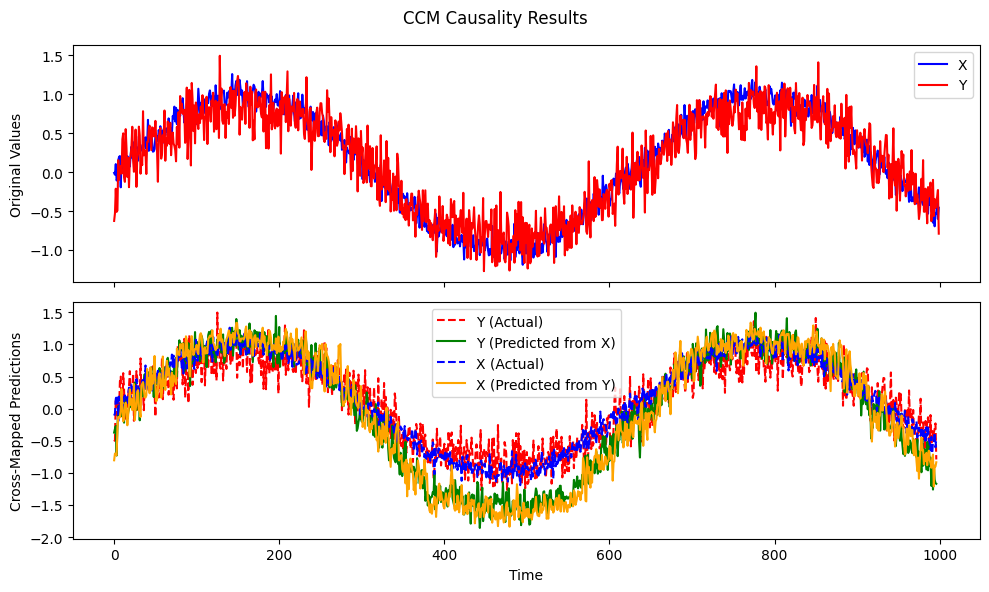

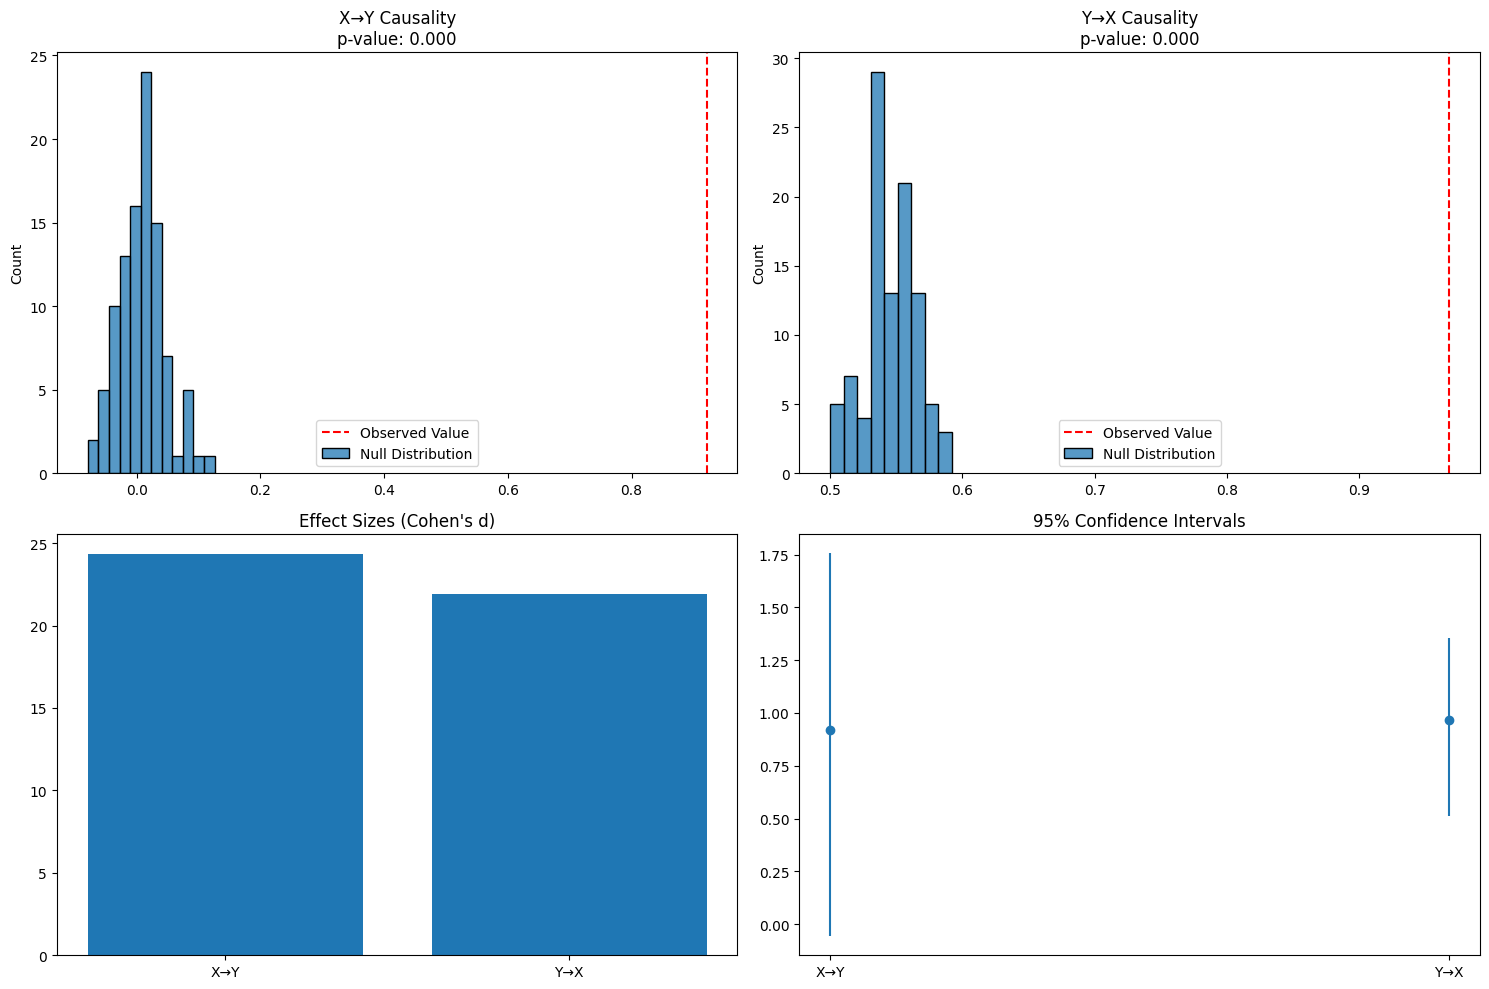

In [28]:
# @title Main playground
def main():
    """
    Main function with statistical significance testing.
    """
    # Generate test data
    print("Generating test data...")
    n_points = 1000
    t = np.linspace(0, 10, n_points)
    # sin function with noise
    X = np.sin(t) + 0.1 * np.random.randn(n_points)
    # Shift X back by 5 and apply sin function on top
    Y = np.sin(np.roll(X, 5)) + 0.2 * np.random.randn(n_points)

    # Run causality analysis
    print("\nRunning causality analysis...")
    results = ccm_signature_causality(X, Y)

    # Compute statistical significance
    print("\nComputing statistical significance...")
    significance_results = compute_statistical_significance(X, Y, results)

    # Print interpretations
    print("\nInterpretation of Results:")
    print("-" * 50)
    for interp in interpret_significance_results(significance_results):
        print(interp)

    # Plot results
    plot_ccm_results(X, Y, results)
    plt.show()
    plot_significance_results(results, significance_results)
    plt.show()

    return results, significance_results

if __name__ == "__main__":
    results, significance_results = main()